In [30]:
from sys import path
path.append("C:\\Users\\jerem\\OneDrive - University Of Oregon\\Ion Trapping\\Dissertation")
import fit_coherent_state as fcs
import fit_squeezed_state as fss
import fit_thermal_state as fts
from qutip import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.optimize import curve_fit
import oitg.results as results
import os.path
from statsmodels.stats.proportion import proportion_confint
import math
import copy
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

In [2]:
def get_path(rid):
        
    for root, dirs, files in os.walk('C:\\Users\\jerem\\OneDrive - University Of Oregon\\Ion Trapping\\Dissertation\\'):
        for name in files:
            if rid in name:
                path = os.path.join(root, name)

    return path
                        
        
def get_data(path):


    data = results.load_hdf5_file(path)
    pop = data['datasets']['ndscan.points.channel_ion_bright']
    x = data['datasets']['ndscan.points.axis_0']
    
    return x, pop

def get_std(prob,N):
    std = []
    for p in prob:
        k = p*N
        confint = proportion_confint(k, N, alpha=0.3173, method='beta')
        uncertainty = (confint[1]-confint[0])/2
        std.append(uncertainty)
    return std
def line(t,m,b):
    return m*t+b

# displacement calibration

[1.00000000e-01 7.38729345e+05 6.20022312e-02 1.00000000e+02]


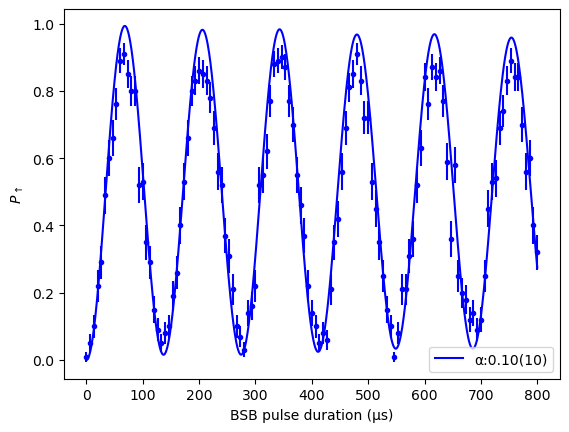

<Figure size 640x480 with 0 Axes>

[9.65355147e-01 7.36089068e+05 6.14702221e-02 1.00000000e+02]


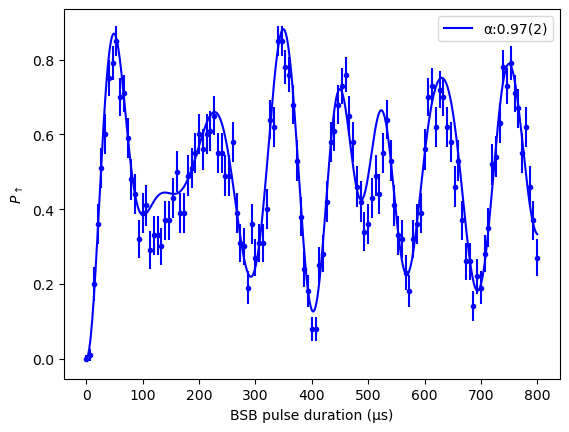

<Figure size 640x480 with 0 Axes>

[1.80793465e+00 7.32075626e+05 6.07038132e-02 1.00000000e+02]


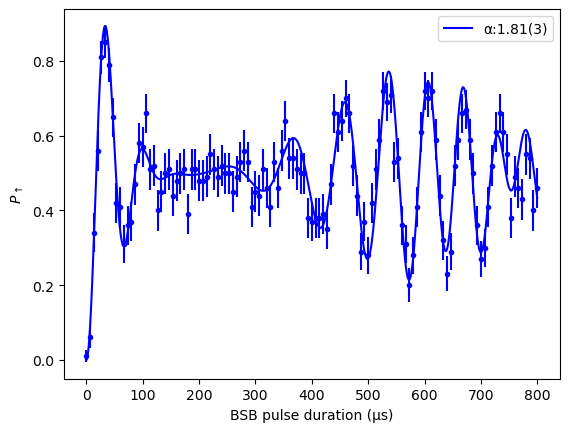

<Figure size 640x480 with 0 Axes>

[2.58338739e+00 7.31750923e+05 6.05922939e-02 1.00000000e+02]


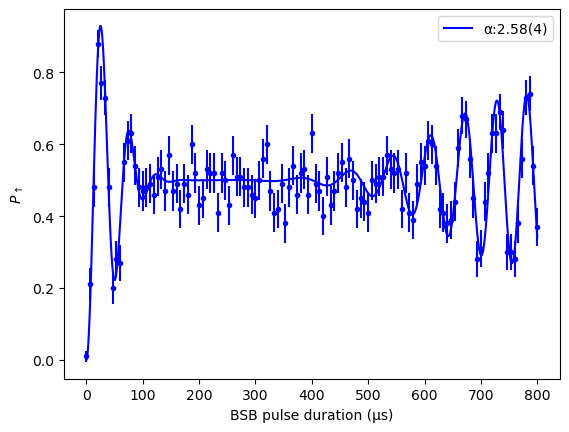

<Figure size 640x480 with 0 Axes>

[3.40099873e+00 7.29948391e+05 6.02241057e-02 1.00000000e+02]


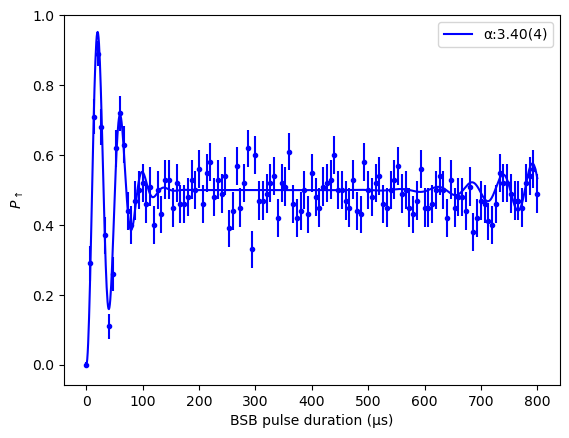

<Figure size 640x480 with 0 Axes>

[4.05662221e+00 7.36451990e+05 6.13017419e-02 2.59611037e+01]


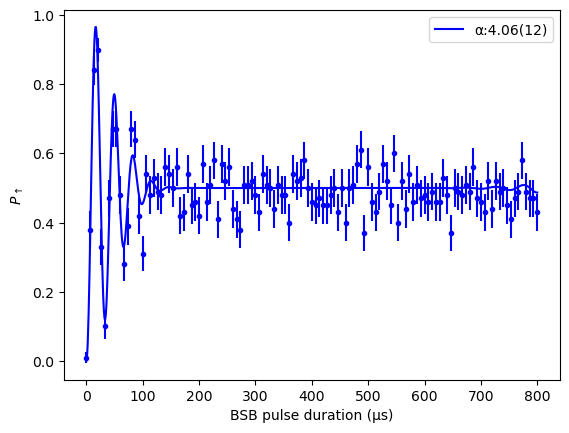

<Figure size 640x480 with 0 Axes>

[4.98169058e+00 7.28881363e+05 6.00367197e-02 2.83060536e+00]


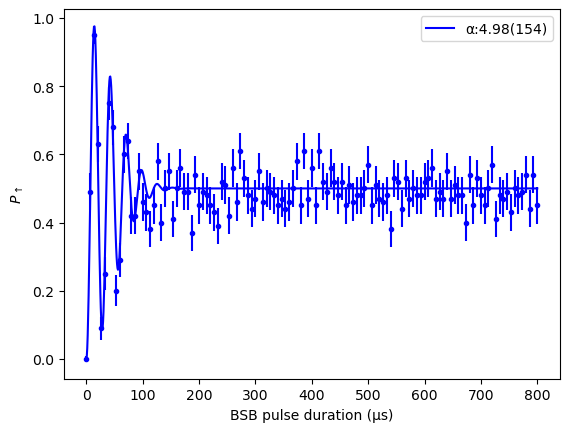

<Figure size 640x480 with 0 Axes>

In [3]:
rids = ['58845','58844','58843','58842','58841','58840','58839']
i=0
alpha_su2 = []
alpha_std_su2 = []
alpha_bound = [0.1,1.5,2.5,3.5,4.5,5.5,6.5]
for rid in rids:
    bound = ((0,2*np.pi*116e3,0.060,0),(alpha_bound[i],2*np.pi*118e3,0.0625,1e2))
    t, pop = get_data(get_path(rid))
    fitting = fcs.Fit_coherent_state(t,pop,bounds = bound,num_shots=100)
    fit = fitting.fit_coherent_state()
    alpha_su2.append(fit[0][0])
    alpha_std_su2.append(np.sqrt(np.diag(fit[1]))[0])
    fitting.plot_fit('b')
    plt.figure()
    plt.show()
    i+=1

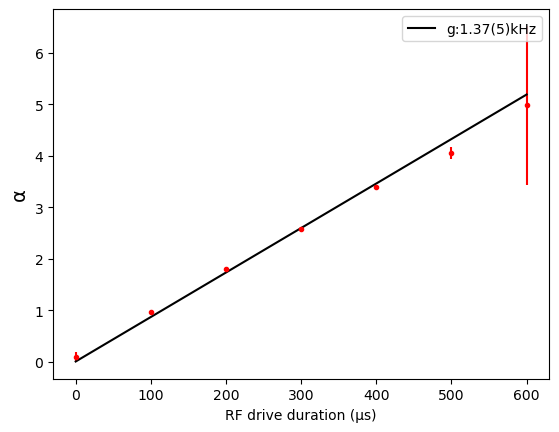

In [4]:

ts_exp = np.array([0,100,200,300,400,500,600])
bounds = ((0,0),(0.01,.01))
plt.errorbar(ts_exp,alpha_su2,alpha_std_su2,marker = '.',ls = 'none', c= 'r')
fit_su2_g, fit_su2_g_std = curve_fit(line,ts_exp,alpha_su2,sigma=alpha_std_su2,bounds = bounds)
disp_coupling_std = np.sqrt(np.diag(fit_su2_g_std))[0]
plt.plot(ts_exp,line(ts_exp,*fit_su2_g),c = 'k', label = 'g:{:.2f}({:.0f})kHz'.format(fit_su2_g[0]*1e3/(2*np.pi),disp_coupling_std*1e5/(2*np.pi)))
plt.xlabel('RF drive duration (μs)')
plt.ylabel('α', fontsize = 14)
plt.legend();
#plt.savefig('Z:\\Shared\\Conferences\\OMQ Symposium 23\\Sensing_poster\\disp_coupling.pdf', format = 'pdf',bbox_inches='tight')

# squeezing calibration

In [5]:
def Squeeze_overlap(t_rsb,r,δ,Ω,γs,C):
    N = 80
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))
    sz = tensor(sigmaz(),qeye(N),qeye(N))
    η1 = 0.042
    η2 = 0.064

    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)
    
    def H_s_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_s_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

    bsp = []


    t_s = np.linspace(0,120e-6,2)
    g_s = r/120e-6
    H_s = g_s/2*(a**2+a.dag()**2)
    H_b1 = g_s/2*b**2
    H_b2 = g_s/2*b.dag()**2
    H_sb = [H_s,[H_b1,H_s_t],[H_b2,H_s_td]]
    

    args = {'δ':δ}
    ψ0 = tensor(basis(2,1),basis(N,0),basis(N,0))
    S_out = mesolve(H_sb,ψ0,t_s,args = args)
    RSB = mesolve(H,S_out.states[-1],t_rsb,args = args)
    for state in RSB.states:
        bsp.append(np.real(state.ptrace(0)[0,0]))
    return C*np.array(bsp)*(0.5*(np.exp(-γs*t_rsb))+0.5)

0.009999999999999998 -0.0002984808707819139 115.01237068693884
399.99999999999994


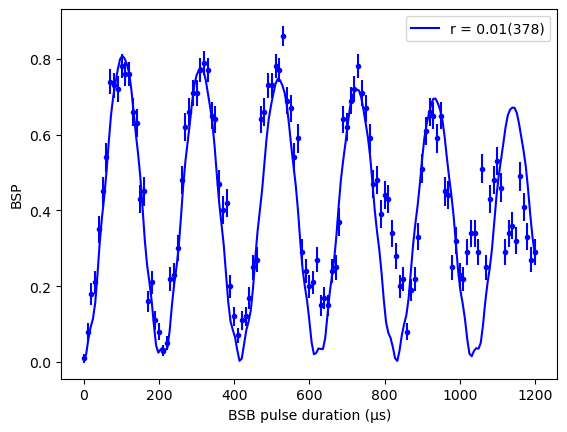

0.5279999999999999 -0.0015915493395786378 114.85651909850795
399.99999999999994


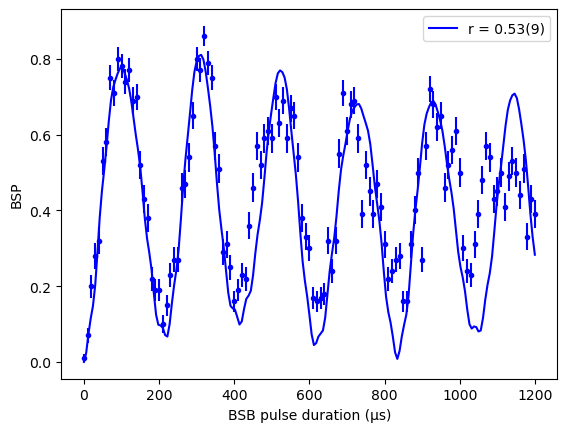

1.0459999999999998 -0.0015915494309189533 113.04674323064577
399.99999999999994


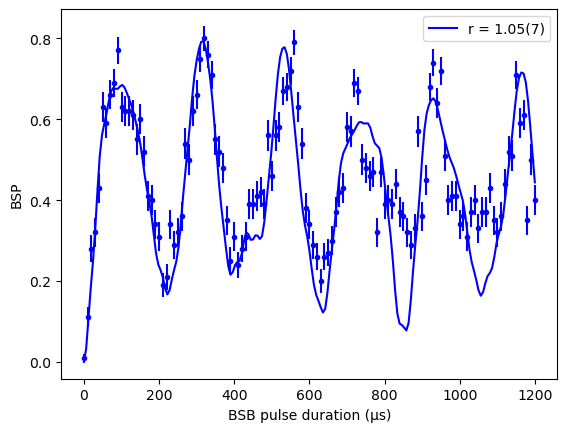

1.5639999999999998 -0.0015915494309189533 108.49021045256207
177.87838832696673


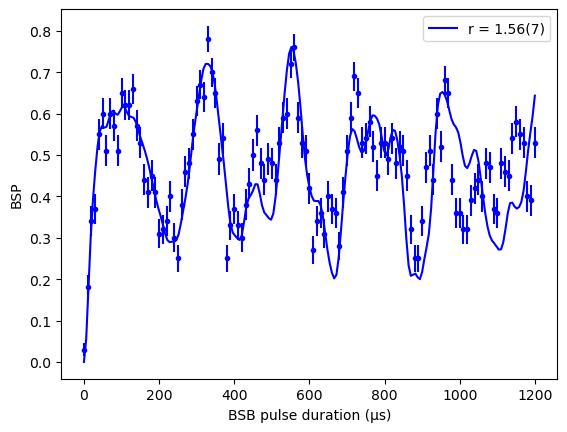

2.0819999999999994 -0.0015915494309189533 108.94972892928689
83.45307476427622


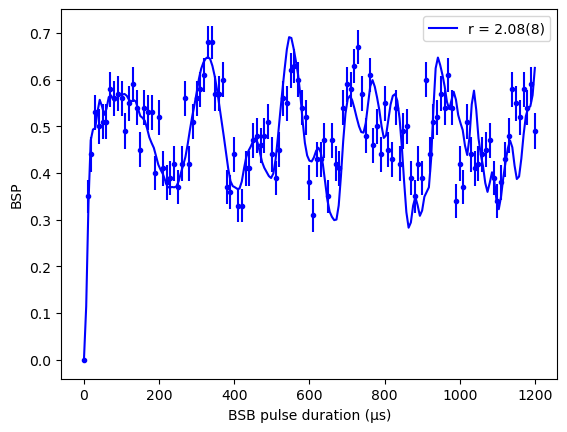

2.496331147715108 -0.0015915494309189533 108.71834332953902
1.1363706472021663e-66


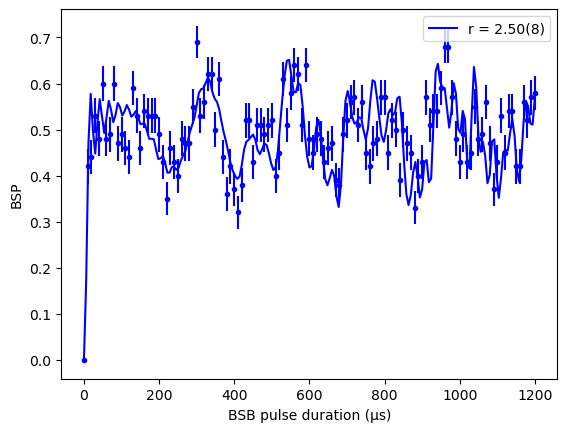

In [7]:
rids = [61160,61158,61156,61154,61152,61150]
rs = np.linspace(0.01,2.6,6)
i=0
rs_squeezed3 = []
rs_std_squeezed3 = []
for rid in rids:
    plt.figure()
    ts, bp = get_data(get_path(str(int(rid))))
    ts_fit  = np.linspace(ts[0],ts[-1],201)
    bounds = ((0,-10,2*np.pi*107e3,0,0.5),(rs[i],10,2*np.pi*115.5e3,400,1))
    fit, fit_cov = curve_fit(Squeeze_overlap,ts,bp,bounds = bounds)
    plt.errorbar(ts*1e6,bp,get_std(bp,200),marker = '.',ls = 'none', c= 'b')
    plt.plot(ts_fit*1e6,Squeeze_overlap(ts_fit,*fit), c= 'b',label = 'r = {:.2f}({:.0f})'.format(fit[0], 100*np.sqrt(np.diag(fit_cov))[0]))
    print(fit[0],fit[1]/(2*np.pi*1e3),fit[2]/(2*np.pi*1e3))
    print(fit[3])
    rs_squeezed3.append(fit[0])
    rs_std_squeezed3.append(np.sqrt(np.diag(fit_cov))[0])
    plt.xlabel('BSB pulse duration (μs)')
    plt.ylabel('BSP')
    plt.legend();
    i+=1
    plt.show()


Text(0, 0.5, 'r_fit')

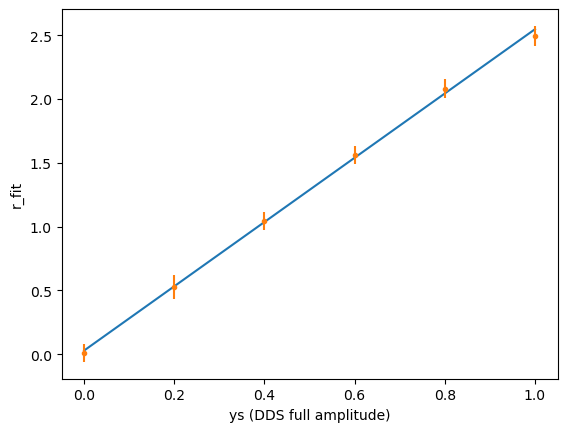

In [8]:
rs_std_squeezed3[0] = 0.07
ys = np.array([0.0,0.2,0.4,0.6,0.8,1.0])
bounds = ((0,0),(4,0.2))
fit_squeeze_coupling3, fit_squeeze_coupling_cov3 = curve_fit(line,ys,rs_squeezed3,sigma = rs_std_squeezed3, bounds = bounds)

plt.plot(ys,line(ys,*fit_squeeze_coupling3))
plt.errorbar(ys,rs_squeezed3,rs_std_squeezed3,marker = '.',ls = 'none')
plt.xlabel('ys (DDS full amplitude)')
plt.ylabel('r_fit')

# TMS calibration

In [9]:
def TMS_overlap(t_rsb,r,δ,Ω):
    N = 40
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))

    η1 = 0.042
    η2 = 0.064


    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

    bsp = []


    g = 1.6e3
    g = 2*np.pi*g
    H_TMS = g*(a*b+a.dag()*b.dag())
    t_TMS = np.linspace(0,r/g,2)

    args = {'δ':δ}
    ψ0 = tensor(basis(2,1),basis(N,0),basis(N,0))
    TMS_out = mesolve(H_TMS,ψ0,t_TMS)
    RSB = mesolve(H,TMS_out.states[-1],t_rsb,args = args)
    for state in RSB.states:
        bsp.append(np.real(state.ptrace(0)[0,0]))
    return np.array(bsp)

0.09999999999999999 34.79351805663863 121.99999999999999


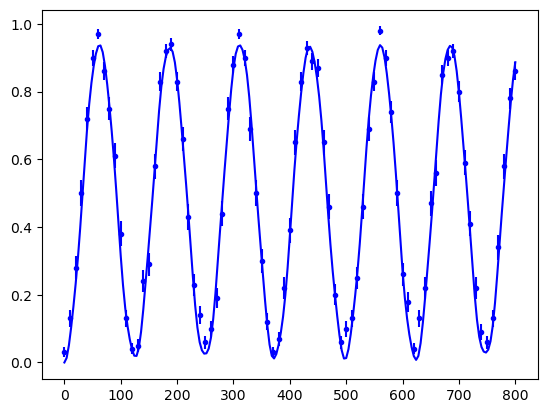

0.38362008523787583 34.82270592795469 121.99999999999999


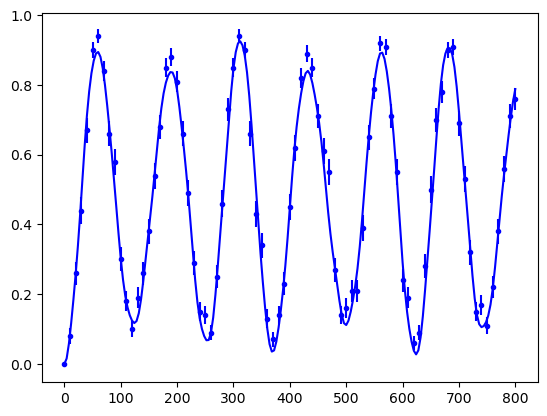

0.7977612909554876 34.84391049151343 121.99999999999999


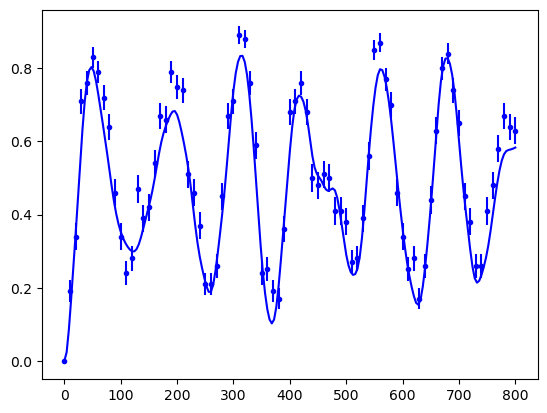

1.1412477529608762 34.8786654257812 121.31134089225688


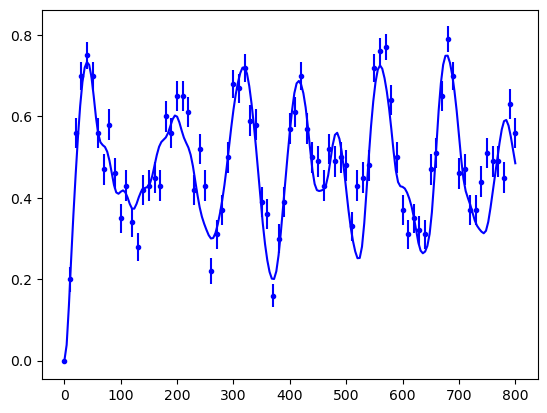

1.4947579970444875 34.99999999999999 120.98494569544414


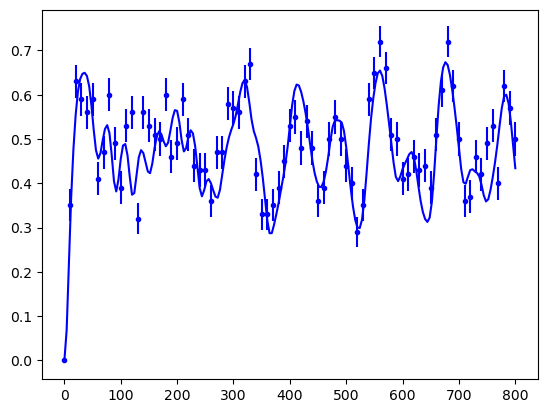

1.761360900443014 34.999999999988404 120.38788757264562


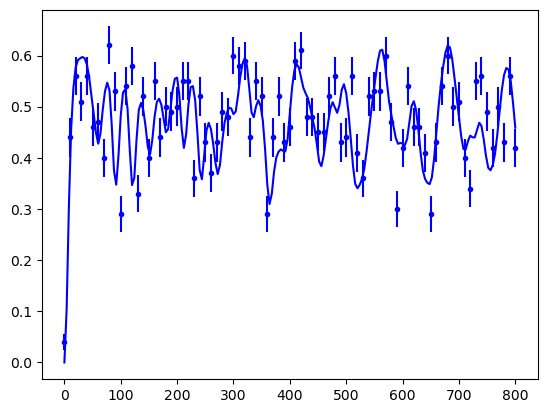

In [10]:
rids = [53517,53524,53522,53526,53520,53528]
rs = np.linspace(0.1,3,6)
TMS_fit_std = []
i=0
TMS_fit = []
for rid in rids:
    plt.figure()
    ts, bp = get_data(get_path(str(int(rid))))
    ts_fit  = np.linspace(ts[0],ts[-1],201)
    bounds = ((0,2*np.pi*32e3,2*np.pi*118e3),(rs[i],2*np.pi*35e3,2*np.pi*122e3))
    fit, fit_cov = curve_fit(TMS_overlap,ts,bp,bounds = bounds)
    plt.errorbar(ts*1e6,bp,get_std(bp,200),marker = '.',ls = 'none', c= 'b')
    plt.plot(ts_fit*1e6,TMS_overlap(ts_fit,*fit), c= 'b',label = 'r = {:.2f}'.format(fit[0]))
    print(fit[0],fit[1]/(2*np.pi*1e3),fit[2]/(2*np.pi*1e3))
    i+=1
    plt.show()
    TMS_fit.append(fit[0])
    TMS_fit_std.append(np.sqrt(np.diag(fit_cov))[0])

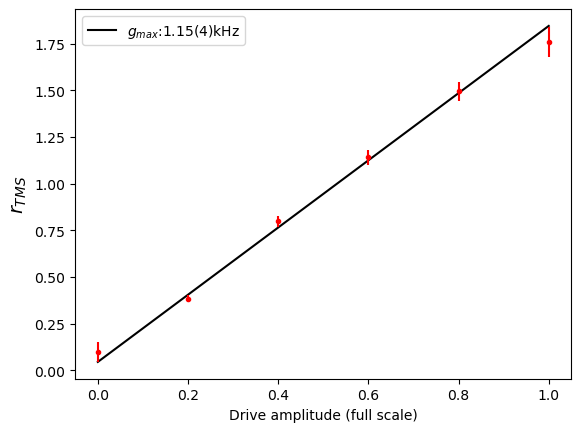

In [11]:
ys = np.linspace(0,1,6)
TMS_coupling, TMS_coupling_cov = curve_fit(line,ys,TMS_fit,sigma = TMS_fit_std)

TMS_coupling_std = np.sqrt(np.diag(TMS_coupling_cov))[0]
plt.plot(ys,line(ys,*TMS_coupling),c='k', label = r'$g_{max}$'+':{:.2f}({:.0f})kHz'.format(TMS_coupling[0]/(2*np.pi*250e-3),TMS_coupling_std/(2*np.pi*250e-5)))
plt.errorbar(ys,TMS_fit,TMS_fit_std,marker = '.', ls = 'none', c='r')
plt.legend()
plt.ylabel(r'$r_{TMS}$',fontsize = 14)
plt.xlabel('Drive amplitude (full scale)')
plt.savefig('tms_coupling.png', format = 'png',bbox_inches='tight')

# SU(2) phase scans

In [12]:
def SU2_model(θs,α_0,width, shift,offset,Ω = 2*np.pi*39e3, t= 60e-6, η = 0.042):
    Ns = 100

    probs = []
    offsets = np.linspace(-width+shift,width+shift,400)
    for θ in (θs):
        θ = θ - offsets
        α = α_0*np.sin(θ/2)
        exp = 0
        deriv = 0
        for n in range(Ns):

            A = np.cos(η*Ω/2*t*np.sqrt(n))**2
            exp =exp+ np.exp(-α**2)*α**(2*n)*A/math.factorial(n)
            deriv=deriv+ np.exp(-α**2)*α_0*np.cos(θ/2)*A*(-α**(2*n+1)+n*α**(2*n-1))/math.factorial(n)

        probs.append(np.mean(exp))
    return (1-np.array(probs))+offset

In [13]:
def SU2_sensitivity(θs,α_0,width, shift,offset,Ω = 2*np.pi*39e3, t= 60e-6, η = 0.042):
    Ns = 100

    variance = []
    dvals = []
    vals = []
    offsets = np.linspace(-width+shift,width+shift,400)
    for θ in (θs):
        θ = θ - offsets
        α = α_0*np.sin(θ/2)
        exp = 0
        deriv = 0
        for n in range(Ns):

            A = np.cos(η*Ω/2*t*np.sqrt(n))**2
            exp=exp+ np.exp(-α**2)*α**(2*n)*A/int(math.factorial(n))
            deriv=deriv+ np.exp(-α**2)*α_0*np.cos(θ/2)*A*(-α**(2*n+1)+n*α**(2*n-1))/math.factorial(n)
        
        exp = exp-offset
        #exp[exp>1]=1
        vals.append(np.mean(exp))
        dvals.append(np.mean(deriv))
        variance.append(np.sqrt(np.mean(exp)-np.mean(exp)**2))
    

    return min(abs(np.array(variance)/np.array(dvals))) 

[9.54195692e-01 2.06360297e-04 1.38256263e+00 3.33955358e-02]
[1.42826658e+00 4.95330999e-01 1.39318608e+00 3.13898499e-19]
[1.65171710e+00 4.25578648e-01 1.35262821e+00 1.94432573e-11]
[ 1.91307814  0.4         1.33530992 -0.00774483]
[ 3.60151912  0.4         1.31874492 -0.10380634]
[ 4.03235467  0.35056333  1.29682514 -0.08390109]
[ 4.72114026  0.28727565  1.32410707 -0.0844079 ]
[ 5.13907895  0.2776088   1.32771998 -0.09404277]
[ 5.84316866  0.25662003  1.31663137 -0.09592367]
[ 5.97693147  0.23422111  1.28996801 -0.07685566]
[ 6.74212532  0.20294326  1.2945464  -0.0932219 ]
[ 6.81997602  0.20273851  1.26613074 -0.08666292]
[ 7.25329534  0.19044723  1.28395986 -0.07986501]
[ 7.48480977  0.17260573  1.26209298 -0.07911943]
[ 7.741155    0.18244618  1.27834717 -0.10973199]
[ 8.12223964  0.16981211  1.23061638 -0.1113422 ]


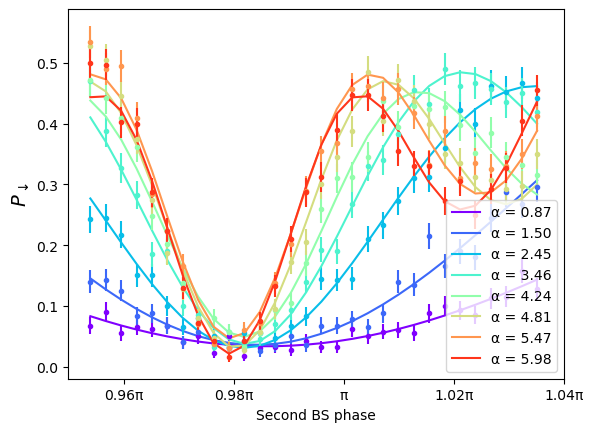

In [14]:
rids = ['59168','59162','59156','59150','59144','59138','59132','59126','59120','59114',
        '59108','59102','59096','59090','59084','59078',]
sense_su2_400 = []
αs_su2_400 = []
i = 0
f = 70e3
ts_su2_exp = np.array([100,141,173,200,283,346,400,447,490,529,556,600,632,663,692,721,748,775,800,825,848,872,894])
alpha_bound_su2 = line(ts_su2_exp,*fit_su2_g)
widths = [1,1,0.5,0.4,0.4,0.4,0.4,0.38,0.35,0.35,0.28,0.28,0.28,0.28,0.28,0.28,0.35,0.28,0.28,0.28,0.28,0.28,0.28]
offsets = np.concatenate([3*[0],5*[-0.15],[-0.1,-0.1,-0.1],[-0.1,-0.15,-0.15,-0.15,-0.15],[-0.1,-0.15,-0.15,-0.15,-0.15,-0.15]])

evenly_spaced_interval = np.linspace(0, 1, len(rids))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

for rid in rids:
    
    ts, bsp = get_data(get_path(rid))
    ϕs = (ts-ts[0])*f*2*np.pi
    
   
    fit, fit_cov = curve_fit(lambda θs,α_0, width, shift,offset: SU2_model(θs,α_0,width, shift,offset, Ω= 2*np.pi*38e3,t = 250e-6,η = 0.042),
                            ϕs[20:50],bsp[20:50], bounds = ((alpha_bound_su2[i]-0.2,0,1.22,offsets[i]),(alpha_bound_su2[i]+2,widths[i],2,0.1)),p0 = [alpha_bound_su2[i]+0.2,0.01,1.5,0])
    print(fit)
    fit_data = SU2_model(ϕs[20:50],*fit, Ω= 2*np.pi*38e3,t = 250e-6,η = 0.042)
    
    fit_sense = SU2_sensitivity(ϕs[20:50],*fit, Ω= 2*np.pi*38e3,t = 250e-6,η = 0.042)
    sense_su2_400.append(fit_sense)
    αs_su2_400.append(fit[0])
    #np.save(rid+'_SU2_400shot',[ϕs,bsp,get_std(bsp,400),fit_data, fit_sense])
    if i%2==0:
        plt.errorbar((ϕs[20:50]+1.852)/(2*np.pi),bsp[20:50],get_std(bsp,400)[20:50],marker = '.', ls = 'none', c= colors[i])
        plt.plot((ϕs[20:50]+1.852)/(2*np.pi),fit_data , c= colors[i], label = 'α = {:.2f}'.format(line(ts_su2_exp,*fit_su2_g)[i]))
        plt.ylabel(r'$P_{\downarrow}$',fontsize = 14)
        plt.xlabel('Second BS phase')
        plt.legend()
        plt.xticks([0.45,0.5,0.55,0.6,0.65],['0.96π','0.98π','π','1.02π','1.04π'])
    
    
    i+=1


In [15]:
rids = ['59168','59162','59156','59150','59144','59138','59132','59126','59120','59114',
        '59108','59102','59096','59090','59084','59078',]

i = 0
t = 0
f = 70e3
ts_su2_exp = np.array([100,141,173,200,283,346,400,447,490,529,556,600,632,663,692,721,748,775,800,825,848,872,894])
alpha_bound_su2 = line(ts_su2_exp,*fit_su2_g)
widths = [1,1,0.5,0.4,0.4,0.4,0.4,0.38,0.35,0.35,0.28,0.28,0.28,0.28,0.28,0.28,0.35,0.28,0.28,0.28,0.28,0.28,0.28]
offsets = np.concatenate([3*[0],5*[-0.15],[-0.1,-0.1,-0.1],[-0.1,-0.15,-0.15,-0.15,-0.15],[-0.1,-0.15,-0.15,-0.15,-0.15,-0.15]])

ϕs_su2 = []
bsp_su2 = []
fits_su2 = []

for rid in rids:
    
    ts, bsp = get_data(get_path(rid))
    ϕs = (ts-ts[0])*f*2*np.pi
    ϕs_su2.append(ϕs)
    bsp_su2.append(bsp)
   
    fit, fit_cov = curve_fit(lambda θs,α_0, width, shift,offset: SU2_model(θs,α_0,width, shift,offset, Ω= 2*np.pi*38e3,t = 250e-6,η = 0.042),
                            ϕs[20:50],bsp[20:50], bounds = ((alpha_bound_su2[i]-0.2,0,1.22,offsets[i]),(alpha_bound_su2[i]+2,widths[i],2,0.1)),p0 = [alpha_bound_su2[i]+0.2,0.01,1.5,0])
    fits_su2.append(fit)
    print(fit)
    ϕs_fit = np.linspace(min(ϕs[20:50]),max(ϕs[20:50]),101)
    fit_data = SU2_model(ϕs_fit,*fit, Ω= 2*np.pi*38e3,t = 250e-6,η = 0.042)
    

    i+=1


[9.54195692e-01 2.06360297e-04 1.38256263e+00 3.33955358e-02]
[1.42826658e+00 4.95330999e-01 1.39318608e+00 3.13898499e-19]
[1.65171710e+00 4.25578648e-01 1.35262821e+00 1.94432573e-11]
[ 1.91307814  0.4         1.33530992 -0.00774483]
[ 3.60151912  0.4         1.31874492 -0.10380634]
[ 4.03235467  0.35056333  1.29682514 -0.08390109]
[ 4.72114026  0.28727565  1.32410707 -0.0844079 ]
[ 5.13907895  0.2776088   1.32771998 -0.09404277]
[ 5.84316866  0.25662003  1.31663137 -0.09592367]
[ 5.97693147  0.23422111  1.28996801 -0.07685566]
[ 6.74212532  0.20294326  1.2945464  -0.0932219 ]
[ 6.81997602  0.20273851  1.26613074 -0.08666292]
[ 7.25329534  0.19044723  1.28395986 -0.07986501]
[ 7.48480977  0.17260573  1.26209298 -0.07911943]
[ 7.741155    0.18244618  1.27834717 -0.10973199]
[ 8.12223964  0.16981211  1.23061638 -0.1113422 ]


# two mode SU(1,1) phase scans

In [16]:
def SU11_model(θs,r_0,width,shift,Ω = 2*np.pi*39e3, t= 60e-6, η = 0.042):
    Ns = 300
#     η = 0.042
#     Ω = 2*np.pi*39.0e3
#     t = 60e-6
    probs = []
    offsets = np.linspace(-width+shift,width+shift,200)
    for θ in 2*np.pi*θs:
        θ = θ - offsets
        r = (np.arcsinh(np.sinh(2*r_0)*(np.cos(θ/2))))
        λ = np.sinh(r)**2#np.cos(θ/2)**2*np.sinh(2*r_0)
        dλ = -2*np.sin(θ)*np.sinh(r_0)**2*np.cosh(r_0)**2
        val1 = 0
        val2 = 0
        for n in range(Ns):
            A = np.cos(η*Ω/2*t*np.sqrt(n))**2
            val1+= (1/(1+λ))*A*(((λ/(1+λ))**n))
        probs.append(np.mean(val1))
    return 1-np.array(probs)

In [17]:
def SU11_sensitivity(θs,r_0,width, shift,Ω = 2*np.pi*39e3, t= 60e-6, η = 0.042):
    Ns = 300
#     η = 0.064
#     Ω = 2*np.pi*100e3
#     t = 60e-6

    probs = []
    dvals = []
    variance = []
        
    offsets = np.linspace(-width+shift,width+shift,200)
    for θ in 2*np.pi*θs:
        θ = θ - offsets
        r = (np.arcsinh(np.sinh(2*r_0)*(np.cos(θ/2))))
        λ = np.sinh(r)**2#np.cos(θ/2)**2*np.sinh(2*r_0)
        dλ = -2*np.sin(θ)*np.sinh(r_0)**2*np.cosh(r_0)**2
        val1 = 0
        val2 = 0
        for n in range(Ns):

            A = np.cos(η*Ω/2*t*np.sqrt(n))**2
            val1+= (1/(1+λ))*A*(((λ/(1+λ))**n))
            val2+= A*n*(λ/(1+λ))**(n-1)*((1/(1+λ))-(λ/(1+λ)**2))


        f_val = (dλ/(1+λ))*(-val1+val2)
        probs.append(np.mean(val1))
        dvals.append(np.mean(f_val))
        variance.append(np.mean(np.sqrt(val1-val1**2)))

    return min(abs(np.array(variance)/np.array(dvals))) 

[ 1.10097886  0.18375197 -0.00372443]
[1.32978625e+00 1.23488570e-01 4.54084860e-04]
[ 1.47496752e+00  8.88048995e-02 -3.17285093e-04]
[1.51829138 0.09816659 0.00440876]
[ 1.70368979e+00  6.29295782e-02 -9.20821200e-04]
[ 1.75497304e+00  6.66834727e-02 -1.43735276e-03]
[ 1.79408806  0.05497927 -0.00407011]
[ 1.83088967  0.06331945 -0.003537  ]
[ 1.88468973  0.05930349 -0.00206229]
[ 1.90395079  0.05236702 -0.00463262]


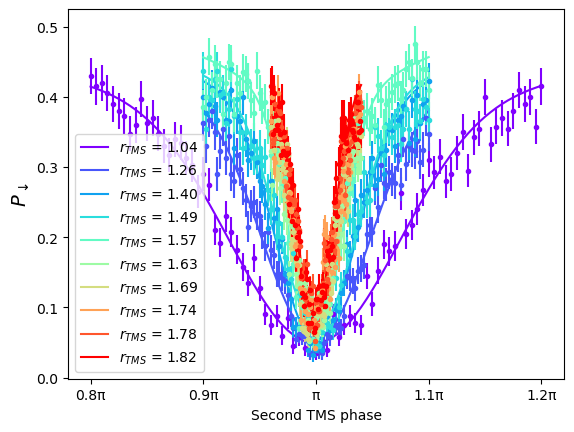

In [18]:
rids = ['53197','53199','53201','53203','53350','53352','53354','53356','53207','53209','53211','53213',
        '53669','53671','53673','53675','53216','53218','53220','53222','53443','53445','53447','53449',
        '53332','53334','53336','53338','53602','53604','53606','53608','53340','53342','53344','53346',
       '53502','53504','53506','53508']

evenly_spaced_interval = np.linspace(0, 1, int(len(rids)/4))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

ys_TMS = np.array([0.5522,0.6739,0.7500,0.8043,0.8456,0.8826,0.9130,0.9391,0.9630,0.9848])

sense_su11 = []
rs_su11 = []
i = 0
data = []
j = 0
for rid in rids:
    
    
    ϕs, bsp = get_data(get_path(rid))
    data.append(bsp)
    if (i+1)%4==0:
        bsp = np.mean(data,axis = 0)
        plt.errorbar(ϕs,bsp,get_std(bsp,400),marker = '.', ls = 'none', c= colors[j])
        fit, fit_cov = curve_fit(lambda ϕs,r_0, width, shift: SU11_model(ϕs,r_0,width, shift, Ω= 2*np.pi*40.3e3,t = 270e-6,η = 0.042),
                                ϕs,bsp, bounds = ((0,0,-1),(4,3,1)))
        print(fit)
        plt.plot(ϕs, SU11_model(ϕs,*fit, Ω= 2*np.pi*40.1e3,t = 270e-6,η = 0.042), c= colors[j], label = r'$r_{TMS}$'+' = {:.2f}'.format(line(ys_TMS,*TMS_coupling)[j]))
        sense_su11.append(SU11_sensitivity(ϕs,*fit, Ω= 2*np.pi*40.3e3,t = 270e-6,η = 0.042))
        rs_su11.append(fit[0])
        plt.xlabel('Second TMS phase')
        plt.ylabel(r'$P_{\downarrow}$',fontsize = 14)
        plt.xticks([0.4,0.45,0.5,0.55,0.6],['0.8π','0.9π','π','1.1π','1.2π'])
        plt.legend();
        data = []
        j+=1
    i+=1

In [19]:
rids = ['53197','53199','53201','53203','53350','53352','53354','53356','53207','53209','53211','53213',
        '53669','53671','53673','53675','53216','53218','53220','53222','53443','53445','53447','53449',
        '53332','53334','53336','53338','53602','53604','53606','53608','53340','53342','53344','53346',
       '53502','53504','53506','53508']

ys_TMS = np.array([0.5522,0.6739,0.7500,0.8043,0.8456,0.8826,0.9130,0.9391,0.9630,0.9848])

i = 0
data = []
j = 0
t = 0

ϕs_tm_su11 = []
bsp_tm_su11 = []
fits_tm_su11 = []
for rid in rids:
    
    ϕs, bsp = get_data(get_path(rid))
    data.append(bsp)
    if (i+1)%4==0:
        bsp = np.mean(data,axis = 0)
        ϕs_tm_su11.append(ϕs)
        bsp_tm_su11.append(bsp)
        
        
            
        fit, fit_cov = curve_fit(lambda ϕs,r_0, width, shift: SU11_model(ϕs,r_0,width, shift, Ω= 2*np.pi*40.3e3,t = 270e-6,η = 0.042),
                                ϕs,bsp, bounds = ((0,0,-1),(4,3,1)))
        print(fit)
        fits_tm_su11.append(fit)
        j+=1
        data = []
              
    i+=1


[ 1.10097886  0.18375197 -0.00372443]
[1.32978625e+00 1.23488570e-01 4.54084860e-04]
[ 1.47496752e+00  8.88048995e-02 -3.17285093e-04]
[1.51829138 0.09816659 0.00440876]
[ 1.70368979e+00  6.29295782e-02 -9.20821200e-04]
[ 1.75497304e+00  6.66834727e-02 -1.43735276e-03]
[ 1.79408806  0.05497927 -0.00407011]
[ 1.83088967  0.06331945 -0.003537  ]
[ 1.88468973  0.05930349 -0.00206229]
[ 1.90395079  0.05236702 -0.00463262]


# single mode SU(1,1) phase scans

In [22]:
def SuS_output(θs,r_0,width, shift, offset,t = 180e-6, Ω = 2*np.pi*37e3, η = 0.042):
    N = 85


    variance = []
    dvals = []
    probs = []

    offsets = np.linspace(-width+shift,width+shift,400)
    for θ in θs:
        θ = θ - offsets
        r = (np.arcsinh(np.sinh(2*r_0)*(np.cos(θ/2))))
        λ = np.sinh(r)
        val1 = 0
        deriv = 0
        for n in range(N):
            A = np.cos(η*Ω/2*t*np.sqrt(2*n))**2
            val1= val1+ 1/np.cosh(r)*A*(np.tanh(r))**(2*n)*math.factorial(2*n)/(2**n*math.factorial(n))**2
            
            deriv= deriv+ (λ/np.sqrt((1+λ**2)))**(2*n)*(-2*n+λ**2)*np.tan(θ/2)/(2*(1+λ**2)**(3/2))*A*math.factorial(2*n)/(2**n*math.factorial(n))**2


        #variance.append(np.sqrt(val1-val1**2))
        probs.append(np.mean(val1))
        #dvals.append(deriv)

    return 1-np.array(probs)+offset
def SuS_sense_output(θs,r_0,width, shift, offset,t = 180e-6, Ω = 2*np.pi*37e3, η = 0.042):
    N = 85


    variance = []
    dvals = []
    probs = []

    offsets = np.linspace(-width+shift,width+shift,400)
    for θ in θs:
        θ = θ - offsets
        r = (np.arcsinh(np.sinh(2*r_0)*(np.cos(θ/2))))
        λ = np.sinh(r)
        val1 = 0
        deriv = 0
        for n in range(N):
            A = np.cos(η*Ω/2*t*np.sqrt(2*n))**2
            val1= val1+ 1/np.cosh(r)*A*(np.tanh(r))**(2*n)*math.factorial(2*n)/(2**n*math.factorial(n))**2
            
            deriv= deriv+ (λ/np.sqrt((1+λ**2)))**(2*n)*(-2*n+λ**2)*np.tan(θ/2)/(2*(1+λ**2)**(3/2))*A*math.factorial(2*n)/(2**n*math.factorial(n))**2


        variance.append(np.sqrt(np.mean(val1)-np.mean(val1)**2))
        probs.append(np.mean(val1))
        dvals.append(np.mean(deriv))

    return min(abs(np.array(variance)/np.array(dvals)))

[1.52879641 0.0745719  0.05406012 0.00435017]
[ 2.08100935  0.07100108  0.03091595 -0.09708398]
[1.9471023  0.02104589 0.0253175  0.02732476]
[ 2.49635383  0.04038778  0.01595422 -0.11819528]
[ 2.37693397  0.02753102  0.01233315 -0.04067015]
[ 2.61800064  0.0309111   0.00924799 -0.10978938]
[ 2.47645556  0.0247377   0.00648396 -0.04260121]
[2.31956438e+00 2.88891661e-02 1.27767330e-03 5.15866239e-03]
[ 2.59138432e+00  2.28926906e-02  1.06925034e-03 -5.49296898e-02]
[ 2.81316725e+00  2.78573876e-02  3.45351529e-04 -1.08735663e-01]


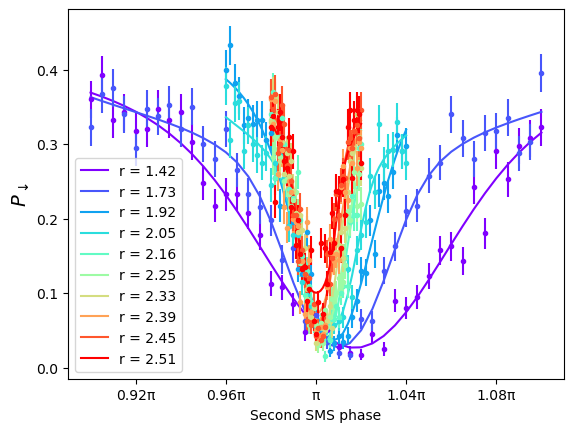

In [24]:
rids = ['61066','61068','61070','61072','61110','61112','61114','61118','61058','61060','61062','61064',
        '61102','61104','61106','61108','61050','61052','61054','61056','61094','61096','61098','61100',
        '61042','61044','61046','61048','61086','61088','61090','61092','61034','61036','61038','61040',
        '61078','61080','61082','61084']

evenly_spaced_interval = np.linspace(0, 1, int(len(rids)/4))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

ys_SuS = np.array([0.5522,.6739,0.75,0.8043,0.8456,0.8826,0.9130,0.9391,0.9630,0.9848])
r_expect = line(ys_SuS,*fit_squeeze_coupling3)
i = 0
j = 0
sense_SuS_test_4x100 = []
data = []
for rid in rids:
    ϕs, bsp = get_data(get_path(rid))
    ϕs = 2*np.pi*ϕs
    sort = np.argsort(ϕs)
    ϕs = ϕs[sort]
    bsp = bsp[sort]
    data.append(bsp)
    if (j+1)%4==0:
        bsp = np.mean(data,axis = 0)
        plt.errorbar(ϕs/(2*np.pi),bsp,get_std(bsp,400),marker = '.', ls = 'none', c= colors[i])
        fit, fit_cov = curve_fit(lambda θs,r_0, width, shift,offset: SuS_output(θs,r_0,width, shift,offset,t = 180e-6),
                                ϕs,bsp, bounds = ((r_expect[i]-0.2,0,0,-0.2),(r_expect[i]+0.5,0.3,0.2,0.1)),p0 = [r_expect[i],0.01,0,0])
        print(fit)
        fit_data = SuS_output(ϕs,*fit, Ω= 2*np.pi*37e3,t = 180e-6)

        sense_SuS_test_4x100.append(SuS_sense_output(ϕs,*fit,t = 180e-6))
        plt.plot(ϕs/(2*np.pi),fit_data , c = colors[i],label = 'r = {:.2f}'.format(line(ys_SuS,*fit_squeeze_coupling3)[i]))
        plt.xlabel('Second SMS phase')
        plt.ylabel(r'$P_{\downarrow}$',fontsize = 14)
        data = []
        plt.legend();
        plt.xticks([0.46,0.48,0.5,0.52,0.54],['0.92π','0.96π','π','1.04π','1.08π'])
        i+=1
    j+=1

In [25]:
rids = ['61066','61068','61070','61072','61110','61112','61114','61118','61058','61060','61062','61064',
        '61102','61104','61106','61108','61050','61052','61054','61056','61094','61096','61098','61100',
        '61042','61044','61046','61048','61086','61088','61090','61092','61034','61036','61038','61040',
        '61078','61080','61082','61084']



ys_SuS = np.array([0.5522,.6739,0.75,0.8043,0.8456,0.8826,0.9130,0.9391,0.9630,0.9848])
r_expect = line(ys_SuS,*fit_squeeze_coupling3)
i = 0
j = 0

ϕs_sm_su11 = []
bsp_sm_su11 = []
fits_sm_su11 = []

data = []
for rid in rids:
    ϕs, bsp = get_data(get_path(rid))
    ϕs = 2*np.pi*ϕs
    sort = np.argsort(ϕs)
    ϕs = ϕs[sort]
    bsp = bsp[sort]
    data.append(bsp)
    if (j+1)%4==0:
        bsp = np.mean(data,axis = 0)
        ϕs_sm_su11.append(ϕs)
        bsp_sm_su11.append(bsp)
        
        fit, fit_cov = curve_fit(lambda θs,r_0, width, shift,offset: SuS_output(θs,r_0,width, shift,offset,t = 180e-6),
                                ϕs,bsp, bounds = ((r_expect[i]-0.2,0,0,-0.2),(r_expect[i]+0.5,0.3,0.2,0.1)),p0 = [r_expect[i],0.01,0,0])
        print(fit)
        fits_sm_su11.append(fit)
        data = []

        i+=1
    j+=1

[1.52879641 0.0745719  0.05406012 0.00435017]
[ 2.08100935  0.07100108  0.03091595 -0.09708398]
[1.9471023  0.02104589 0.0253175  0.02732476]
[ 2.49635383  0.04038778  0.01595422 -0.11819528]
[ 2.37693397  0.02753102  0.01233315 -0.04067015]
[ 2.61800064  0.0309111   0.00924799 -0.10978938]
[ 2.47645556  0.0247377   0.00648396 -0.04260121]
[2.31956438e+00 2.88891661e-02 1.27767330e-03 5.15866239e-03]
[ 2.59138432e+00  2.28926906e-02  1.06925034e-03 -5.49296898e-02]
[ 2.81316725e+00  2.78573876e-02  3.45351529e-04 -1.08735663e-01]


# nbar uncertainties from calibration

In [26]:
def TMS_std(ys,m,b,m_std,b_std,mb_cov):
    return np.sqrt(ys**2*m_std**2+b_std**2+2*ys*mb_cov)
m_TMS = TMS_coupling[0]
b_TMS = TMS_coupling[1]
m_TMS_std = np.sqrt(np.diag(TMS_coupling_cov))[0]
b_TMS_std = np.sqrt(np.diag(TMS_coupling_cov))[1]
mb_TMS_cov = TMS_coupling_cov[0,1]
TMS_r_std = TMS_std(ys_TMS,m_TMS,b_TMS,m_TMS_std,b_TMS_std,mb_TMS_cov)
TMS_r = line(ys_TMS,*TMS_coupling)
nbar_TMS_std = np.sqrt((4*np.sinh(TMS_r)*np.cosh(TMS_r))**2*np.array(TMS_r_std)**2)
nbar_TMS = 2*np.sinh(line(ys_TMS,*TMS_coupling))**2

ys_sus = np.array([0.5522,.6739,0.75,0.8043,0.8456,0.8826,0.9130,0.9391,0.9630,0.9848])
def SuS_std(ys,m,b,m_std,b_std,mb_cov):
    return np.sqrt(ys**2*m_std**2+b_std**2+2*ys*mb_cov)
m_SuS = fit_squeeze_coupling3[0]
b_SuS = fit_squeeze_coupling3[1]
m_SuS_std = np.sqrt(np.diag(fit_squeeze_coupling_cov3))[0]
b_SuS_std = np.sqrt(np.diag(fit_squeeze_coupling_cov3))[1]
mb_SuS_cov = fit_squeeze_coupling_cov3[0,1]
SuS_r_std = SuS_std(ys_sus,m_SuS,b_SuS,m_SuS_std,b_SuS_std,mb_SuS_cov)
SuS_r = line(ys_sus,*fit_squeeze_coupling3)
nbar_SuS_std = np.sqrt((4*np.sinh(SuS_r)*np.cosh(SuS_r))**2*np.array(SuS_r_std)**2)
nbar_SuS = np.sinh(line(ys_sus,*fit_squeeze_coupling3))**2


ts_su2_exp = np.array([100,141,173,200,283,346,400,447,490,529,556,600,632,663,692,721])
alpha_bound_su2 = line(ts_su2_exp,*fit_su2_g)
def α_std(ts,m,b,m_std,b_std,mb_cov):
    return np.sqrt(ts**2*m_std**2+b_std**2+2*ts*mb_cov)
m_su2 = fit_su2_g[0]
b_su2 = fit_su2_g[1]
m_su2_std = np.sqrt(np.diag(fit_su2_g_std))[0]
b_su2_std = np.sqrt(np.diag(fit_su2_g_std))[1]
mb_su2_cov = fit_su2_g_std[0,1]
αs_std_su2 = α_std(ts_su2_exp,m_su2,b_su2,m_su2_std,b_su2_std,mb_su2_cov)
nbars_std_su2 = 2*alpha_bound_su2*αs_std_su2
nbar_SU2 = line(ts_su2_exp,*fit_su2_g)**2

# Experimental Fisher information

In [28]:
nbar_theory = np.linspace(0.01,40,81)

SU2_sense_theory = []
SU11_sense_theory = []

θs = np.linspace(0.5+1e-3,1,81)*2*np.pi
for nbar in nbar_theory:
    print(nbar)
    SU2_sense_theory.append(SU2_sensitivity(θs,np.sqrt(nbar),0,0,+0.01,Ω = 2*np.pi*38e3, t = 250e-6))
    SU11_sense_theory.append(SU11_sensitivity(θs/(2*np.pi),np.arcsinh(np.sqrt(nbar/2)),0,0,Ω = 2*np.pi*40.3e3, t = 270e-6))
    

0.01
0.509875
1.00975
1.509625
2.0095
2.509375
3.0092499999999998
3.509125
4.009
4.508875
5.00875
5.508625
6.0085
6.508375
7.00825
7.508125
8.008000000000001
8.507875
9.00775
9.507625
10.0075
10.507375
11.00725
11.507125
12.007
12.506875
13.00675
13.506625
14.0065
14.506375
15.00625
15.506125
16.006
16.505875000000003
17.005750000000003
17.505625000000002
18.0055
18.505375
19.005250000000004
19.505125000000003
20.005000000000003
20.504875000000002
21.00475
21.504625
22.004500000000004
22.504375000000003
23.004250000000003
23.504125000000002
24.004
24.503875
25.003750000000004
25.503625000000003
26.003500000000003
26.503375000000002
27.00325
27.503125
28.003000000000004
28.502875000000003
29.002750000000002
29.502625000000002
30.0025
30.502375
31.002250000000004
31.502125000000003
32.002
32.501875
33.00175
33.501625
34.0015
34.501374999999996
35.00125
35.501125
36.001
36.500875
37.00075
37.500625
38.0005
38.500375
39.00025
39.500125
40.0


In [29]:
def SuS_output_sense(r_0,θs,t):
    N = 85
    η = 0.044
    Ω = 2*np.pi*37e3
    variance = []
    dvals = []
    probs = []

    
    for θ in θs:
        r = (np.arcsinh(np.sinh(2*r_0)*(np.cos(θ/2))))
        λ = np.sinh(r)
        val1 = 0
        deriv = 0
        for n in range(N):
            A = np.cos(η*Ω/2*t*np.sqrt(2*n))**2
            val1+= 1/np.cosh(r)*A*(np.tanh(r))**(2*n)*math.factorial(2*n)/(2**n*math.factorial(n))**2
            
            deriv+= (λ/np.sqrt((1+λ**2)))**(2*n)*(-2*n+λ**2)*np.tan(θ/2)/(2*(1+λ**2)**(3/2))*A*math.factorial(2*n)/(2**n*math.factorial(n))**2


        variance.append(np.sqrt(val1-val1**2))
        probs.append(val1)
        dvals.append(deriv)

    return min(abs(np.array(variance)/np.array(dvals)))

nbar_theory = np.linspace(0.01,40,81)
θs = np.linspace(0.5+1e-3,1,81)*2*np.pi
t_rsb = 180e-6
SuS_sense_exp_lim = []
for nbar in nbar_theory:
    SuS_sense_exp_lim.append(SuS_output_sense(np.arcsinh(np.sqrt(nbar)),θs,t_rsb))


# Final plot

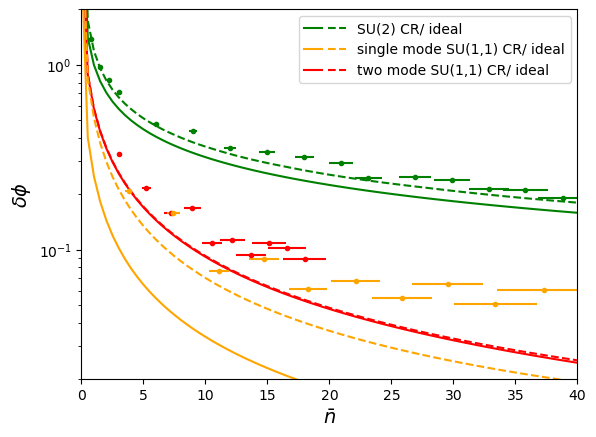

In [53]:
nbar_theory = np.linspace(0.01,40,81)
r_test = np.arcsinh(np.sqrt(nbar_theory))

fig, ax = plt.subplots()

SU2_cr, = ax.semilogy(nbar_theory,1/np.sqrt(nbar_theory),c = 'g', label = 'Standard Quantum limit/ SU(2) CR bound')
SU11_sm_cr, = ax.semilogy(nbar_theory,1/(np.sqrt(8*np.cosh(r_test)**2*np.sinh(r_test)**2)),c = 'orange', label = 'Single mode SU(1,1) CR bound')
SU11_tm_cr, = ax.semilogy(nbar_theory,1/np.sqrt(1*nbar_theory*(2+nbar_theory)),c = 'r', label = 'Two mode SU(1,1) CR bound ')


#HL, = ax.semilogy(nbar_theory,1/nbar_theory,c = 'k', label = 'Heisenberg limit')
SU2_t, = ax.semilogy(nbar_theory,SU2_sense_theory,'--',c = 'g', label = 'SU(2) exp. theory')
SU11_tm_t, = ax.semilogy(nbar_theory,SU11_sense_theory,'--',c = 'r', label = 'SU(1,1) exp. theory')
SU11_sm_t, = ax.semilogy(nbar_theory,SuS_sense_exp_lim,'--',c = 'orange', label = 'single mode SU(1,1) exp. theory')


SU2_d = ax.errorbar(nbar_SU2,sense_su2_400,xerr=nbars_std_su2,marker = '.',ls = 'none',c = 'g')
SU11_tm_d = ax.errorbar(nbar_TMS,sense_su11,xerr = nbar_TMS_std,marker = '.',ls = 'none',c = 'r')
SU11_sm_d = ax.errorbar(nbar_SuS,sense_SuS_test_4x100,xerr = nbar_SuS_std,marker = '.',ls = 'none', c = 'orange')

l = ax.legend([(SU2_cr, SU2_t),(SU11_sm_cr,SU11_sm_t),(SU11_tm_cr,SU11_tm_t)], 
              ['SU(2) CR/ ideal','single mode SU(1,1) CR/ ideal','two mode SU(1,1) CR/ ideal'], numpoints=1,handlelength = 3,
              handler_map={tuple: HandlerTuple(ndivide=None)})



ax.set_xlabel(r'$\bar{n}$', fontsize = 14)
ax.set_ylabel(r'$\delta\phi$',fontsize = 14)
ax.set_ylim(0.02,2)
ax.set_xlim(0,40)
fig.savefig('sensitivity.pdf', format = 'pdf',bbox_inches='tight')

# dB from SQL plot

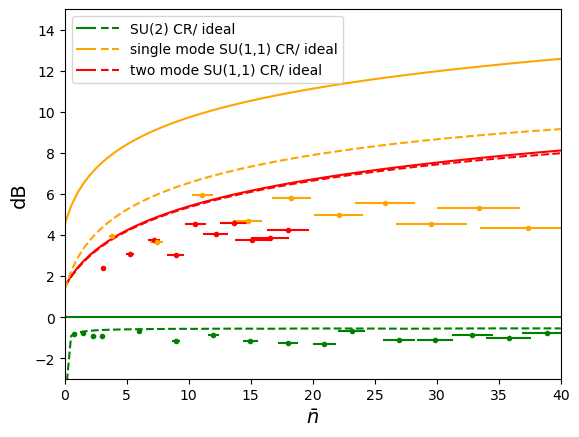

In [57]:
nbar_theory = np.linspace(0.01,40,81)
r_test = np.arcsinh(np.sqrt(nbar_theory))

fig, ax = plt.subplots()


SU11_sm_cr, = ax.plot(nbar_theory,-10*np.log10((1/(np.sqrt(8*nbar_theory*(nbar_theory+1))))/(1/np.sqrt(nbar_theory))),c = 'orange', label = 'Single mode SU(1,1) theory')
SU11_tm_cr, = ax.plot(nbar_theory,-10*np.log10((1/np.sqrt(1*nbar_theory*(2+nbar_theory)))/(1/np.sqrt(nbar_theory))),c = 'r', label = 'SU(1,1) exp')
ax.axhline(0,c = 'g')

#HL, = ax.plot(nbar_theory,-10*np.log10((1/nbar_theory)/(1/np.sqrt(nbar_theory))),c = 'k', label = 'Heisenberg limit')
SU2_t, = ax.plot(nbar_theory,-10*np.log10(SU2_sense_theory/(1/np.sqrt(nbar_theory))),'--',c = 'g', label = 'SU(2) exp. theory')
SU11_tm_t, = ax.plot(nbar_theory,-10*np.log10(SU11_sense_theory/(1/np.sqrt(nbar_theory))),'--',c = 'r', label = 'SU(1,1) exp. theory')
SU11_sm_t, = ax.plot(nbar_theory,-10*np.log10(SuS_sense_exp_lim/(1/np.sqrt(nbar_theory))),'--',c = 'orange', label = 'Single mode SU(1,1) theory')


su2_d = ax.errorbar(nbar_SU2,-10*np.log10(sense_su2_400/(1/np.sqrt(nbar_SU2))),xerr=nbars_std_su2,marker = '.',ls = 'none',c = 'g')
SU11_tm_d = ax.errorbar(nbar_TMS,-10*np.log10(sense_su11/(1/np.sqrt(nbar_TMS))),xerr = nbar_TMS_std,marker = '.',ls = 'none',c = 'r')
SU11_sm_d = ax.errorbar(nbar_SuS,-10*np.log10(sense_SuS_test_4x100/(1/np.sqrt(nbar_SuS))),xerr = nbar_SuS_std,marker = '.',ls = 'none', c = 'orange')

l = ax.legend([(SU2_cr, SU2_t),(SU11_sm_cr,SU11_sm_t),(SU11_tm_cr,SU11_tm_t)], 
              ['SU(2) CR/ ideal','single mode SU(1,1) CR/ ideal','two mode SU(1,1) CR/ ideal'], numpoints=1,handlelength = 3,
              handler_map={tuple: HandlerTuple(ndivide=None)})


ax.set_xlabel(r'$\bar{n}$', fontsize = 14)
ax.set_ylabel('dB',fontsize = 14)
ax.set_ylim(-3,15)

ax.set_xlim(0,40)
plt.savefig('dB_bSQL.pdf', format = 'pdf',bbox_inches='tight')

# Paper phase fringe figures

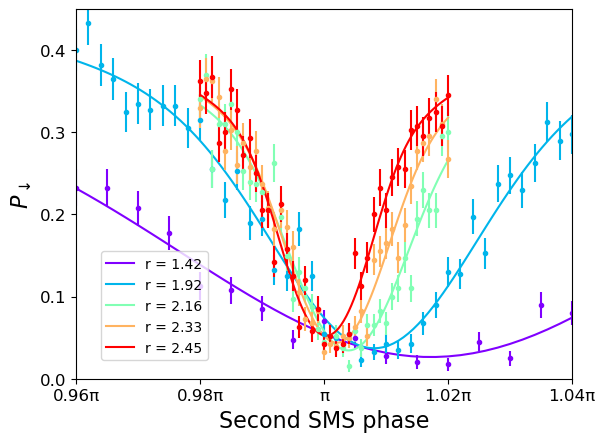

In [54]:
evenly_spaced_interval = np.linspace(0, 1, int(len(fits_sm_su11)/2))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
j=0
for i in range(len(fits_sm_su11)):
    if i%2==0:
        plt.errorbar(ϕs_sm_su11[i]/(2*np.pi),bsp_sm_su11[i],get_std(bsp_sm_su11[i],400),marker = '.', ls = 'none', c= colors[j])
        ϕs_fit = np.linspace(min(ϕs_sm_su11[i]),max(ϕs_sm_su11[i]),101)
        fit_data = SuS_output(ϕs_fit,*fits_sm_su11[i], Ω= 2*np.pi*37e3,t = 180e-6)

        plt.plot(ϕs_fit/(2*np.pi),fit_data , c = colors[j],label = 'r = {:.2f}'.format(line(ys_SuS,*fit_squeeze_coupling3)[i]))
        plt.xlabel('Second SMS phase', fontsize = 16)
        plt.ylabel(r'$P_{\downarrow}$',fontsize = 16)
        data = []
        plt.legend(loc = [0.05,0.05]);
        plt.xticks([0.48,.49,0.5,0.51,0.52],['0.96π','0.98π','π','1.02π','1.04π'],fontsize = 12)
        plt.yticks([0.0,0.1,0.2,0.3,0.4],['0.0','0.1','0.2','0.3','0.4'],fontsize = 12)
        plt.xlim(0.48,0.52)
        plt.ylim(0,0.45)
        j+=1


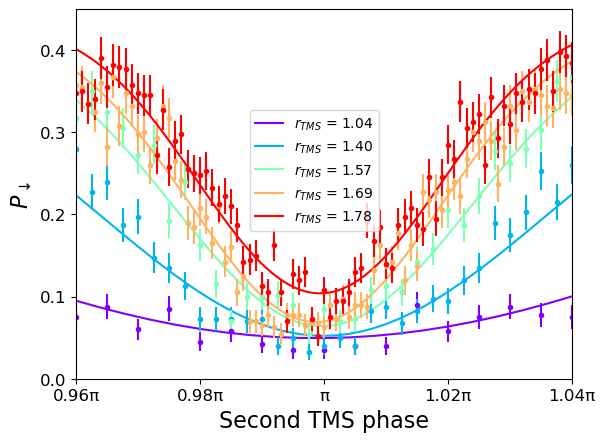

In [55]:
evenly_spaced_interval = np.linspace(0, 1, int(len(fits_tm_su11)/2))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
j=0                                    
for i in range(len(fits_tm_su11)):
    if i%2==0:
        plt.errorbar(ϕs_tm_su11[i],bsp_tm_su11[i],get_std(bsp_tm_su11[i],400),marker = '.', ls = 'none', c= colors[j])
        ϕs_fit = np.linspace(min(ϕs_tm_su11[i]),max(ϕs_tm_su11[i]),101)
        plt.plot(ϕs_fit, SU11_model(ϕs_fit,*fits_tm_su11[i], Ω= 2*np.pi*40.1e3,t = 270e-6,η = 0.042), c= colors[j], label = r'$r_{TMS}$'+' = {:.2f}'.format(line(ys_TMS,*TMS_coupling)[i]))

        plt.xlabel('Second TMS phase',fontsize = 16)
        plt.ylabel(r'$P_{\downarrow}$',fontsize = 16)
        plt.xticks([0.48,.49,0.5,0.51,0.52],['0.96π','0.98π','π','1.02π','1.04π'],fontsize = 12)
        plt.yticks([0.0,0.1,0.2,0.3,0.4],['0.0','0.1','0.2','0.3','0.4'],fontsize = 12)
        plt.xlim(0.48,0.52)
        plt.ylim(0,0.45)
        plt.legend(loc = [0.35,0.4]);
    
        j+=1
plt.savefig('TMS_phase_scan.pdf', format = 'pdf',bbox_inches='tight')

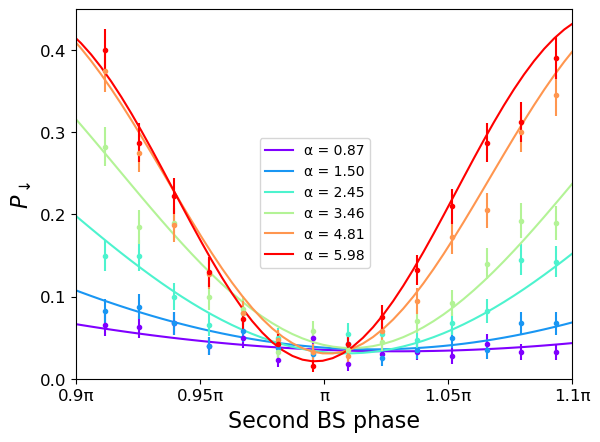

In [56]:
evenly_spaced_interval = np.linspace(0, 1, int(len(fits_su2)/2)-2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
j= 0
for i in range(len(fits_su2)):
    if i%2==0 and i!=8 and i!=12:
        plt.errorbar((ϕs_su2[i][20:50]+1.852)/(2*np.pi),bsp_su2[i][20:50],get_std(bsp_su2[i],400)[20:50],marker = '.', ls = 'none', c= colors[j])
        ϕs_fit = np.linspace(min(ϕs_su2[i][20:50]),max(ϕs_su2[i][20:50]),101)
        fit_data = SU2_model(ϕs_fit,*fits_su2[i], Ω= 2*np.pi*38e3,t = 250e-6,η = 0.042)
        plt.plot((ϕs_fit+1.852)/(2*np.pi),fit_data , c= colors[j], label = 'α = {:.2f}'.format(line(ts_su2_exp,*fit_su2_g)[i]))
        plt.ylabel(r'$P_{\downarrow}$',fontsize = 16)
        plt.xlabel('Second BS phase',fontsize = 16)
        plt.legend( loc = [0.37,0.3])
        plt.xticks([0.45,.475,0.5,0.525,0.55],['0.9π','0.95π','π','1.05π','1.1π'],fontsize = 12)
        plt.yticks([0.0,0.1,0.2,0.3,0.4],['0.0','0.1','0.2','0.3','0.4'],fontsize = 12)
        plt.xlim(0.45,0.55)
        plt.ylim(0,0.45)
        
        ϕs_fit = np.linspace(min(ϕs_sm_su11[-2]),max(ϕs_sm_su11[-2]),101)
        fit_data = SuS_output(ϕs_fit,*fits_sm_su11[-2], Ω= 2*np.pi*37e3,t = 180e-6)

        
        
        
        j+=1
#plt.plot(ϕs_fit/(2*np.pi),fit_data , c = 'k',label = 'r = {:.2f}'.format(line(ys_SuS,*fit_squeeze_coupling3)[-2]))
plt.savefig('SU2_phase_scan.pdf', format = 'pdf',bbox_inches='tight')